# Implementacja operacji konwolucji w Pythonie

**Czasem zdarza się, że chcemy sami stworzyć jakiś filtr by analizować obraz – na przykład podczas wykorzystywania obrazów w uczeniu maszynowym. Wtedy warto wiedzieć, czym jest konwolucja i jak można ją zaimplementować w łatwy sposób. Poniżej pokażemy Ci przykładowe wywołania.**

A czym jest **konwolucja**? Najprościej mówiąc, jest to złożenie dwóch funkcji, w nową, trzecią funkcję. Matematycznych podstaw nie będziemy tu prezentować, polecamy za to gorąco artykuł pod tym adresem: <https://ksopyla.com/python/operacja-splotu-przetwarzanie-obrazow/>. 
W przetwarzaniu obrazów cyfrowych, konwolucję można rozumieć jako używanie wartości z jednej funkcji, jako maski filtrującej, która przesuwa się następnie po całym obrazie.

Tym razem będziemy potrzebować większego zestawu bibliotek – jeśli nie pamiętasz jak się je instaluje, wróć do wstępu tego poradnika. 

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from numba import cuda
from scipy.ndimage.filters import convolve
import cv2

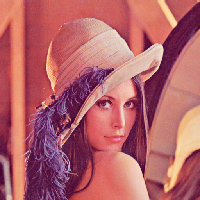

In [2]:
img_pil = Image.open('../obrazy_testowe/lena_512x512.png')
img_pil.resize((200,200))

In [3]:
img_np = np.array(img_pil)/255

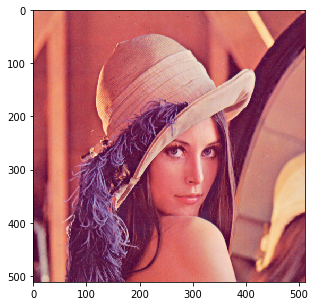

(512, 512, 3)

In [4]:
plt.figure(figsize=(5,5))
plt.imshow(img_np)
plt.show()
img_np.shape

## Filtr średniej 3x3

Pokażemy Ci działanie bardzo prostej maski, która jest po prostu średnią wartością z maski 3x3. Pamiętaj, że przy bardziej skomplikowanych przekształceniach, czas wykonywania obliczeń także się wydłuży, dlatego warto wiedzieć, jak zaoszczędzić sobie trochę czasu ;)

In [5]:
# tworzymy maskę
mean_3_3 = np.array([[1, 1, 1],
                [1, 1, 1],
                [1, 1, 1],],
               dtype='float')/9

* **funkcja wbudowana w bibliotekę *scipy***

In [6]:
%%timeit
img_mean = np.stack([convolve(np.squeeze(img_np[...,i]),mean_3_3) for i in range(3)],axis=-1)

9.84 ms ± 648 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


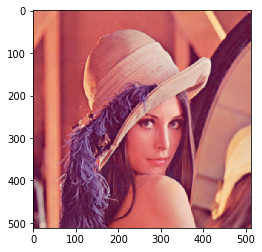

In [7]:
img_mean = np.stack([convolve(np.squeeze(img_np[...,i]),mean_3_3) for i in range(3)],axis=-1)
plt.imshow((img_mean * 255).astype(np.uint8))
plt.show()

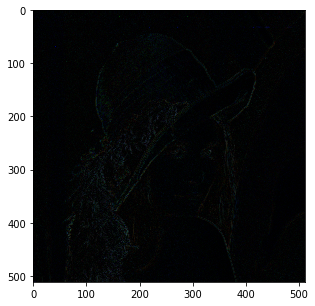

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(np.abs(img_mean-img_np))
plt.show()

* **tym razem funkcja z *OpenCV***

In [9]:
%timeit cv2.filter2D(img_np,-1,mean_3_3)

2.67 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


* **jak zrobić to własnoręcznie z użyciem pętli**

In [10]:
%%timeit
img_mean_fl = img_np.copy()
for i in range(1,img_mean_fl.shape[0]-1):
    for j in range(1,img_mean_fl.shape[1]-1):
        for k in range(3):
            val = 0
            for m in range(-1,2):
                for n in range(-1,2):
                    val+= img_mean_fl[i+m,j+n,k]*mean_3_3[m+1,n+1]
            img_mean_fl[i,j,k] = val

3.39 s ± 73.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
img_mean_fl = img_np.copy()
for i in range(1,img_mean_fl.shape[0]-1):
    for j in range(1,img_mean_fl.shape[1]-1):
        for k in range(3):
            val = 0
            for m in range(-1,2):
                for n in range(-1,2):
                    val+= img_mean_fl[i+m,j+n,k]*mean_3_3[m+1,n+1]
            img_mean_fl[i,j,k] = val

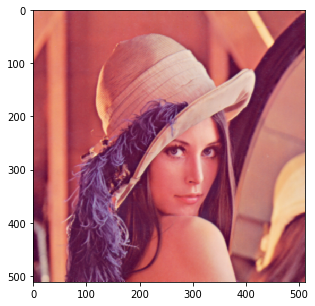

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(img_mean_fl)
plt.show()

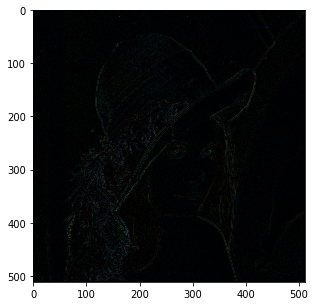

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(np.abs(img_mean_fl-img_np))
plt.show()

* **i jak to wygląda po przyspieszeniu z użyciem pakietu *numba***

In [14]:
img_mean_fl = img_np.copy()
@nb.jit()
def wolna_funkcja_duzo_petli(img_mean_fl):
    for i in range(1,img_mean_fl.shape[0]-1):
        for j in range(1,img_mean_fl.shape[1]-1):
            for k in range(3):
                val = 0
                for m in range(-1,2):
                    for n in range(-1,2):
                        val+= img_mean_fl[i+m,j+n,k]*mean_3_3[m+1,n+1]
                img_mean_fl[i,j,k] = val
    return img_mean_fl

In [15]:
%time img_mean_fl = wolna_funkcja_duzo_petli(img_mean_fl)

CPU times: user 139 ms, sys: 3.54 ms, total: 143 ms
Wall time: 142 ms
